# Table of Contents

* [Import train and test datasets](#Import-train-and-test-datasets)
* [Model Evaluation](#Model-Evaluation)

In [1]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install xgboost
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import ast
import re
%matplotlib inline  
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve

## Import train and test datasets

In [2]:
X_train_new_x = pd.read_csv("X_train_new_x.csv")
y_train_new_0 = pd.read_csv("y_train_new.csv", header=None)
X_test = pd.read_csv("X_test.csv")
y_test_0 = pd.read_csv("y_test.csv", header=None)
y_train_new = y_train_new_0[0]
y_test = y_test_0[0]

In [3]:
print("X train shape: ", X_train_new_x.shape)
print("y train shape: ", y_train_new.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (40209, 350)
y train shape:  (40209,)
X test shape:  (61501, 350)
y test shape:  (61501,)


## Model Evaluation

Based on average cross validation accuracy of the 6 models, the best model selected is LightGBM. Create performance reports on the test data, plot ROC curve and the top 10 features selected by LightGBM.

In [4]:
result = pd.read_csv('lightgbm_cv_rlt.csv')
best_n = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['n_estimators']
best_d = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['max_depth']
best_lr = ast.literal_eval(re.search('({.+})', result.best_params_.values[0]).group(0))['learning_rate']

clf = LGBMClassifier(n_estimators=best_n, learning_rate=best_lr, max_depth=best_d, 
               boosting_type='gbdt', class_weight=None, colsample_bytree=1,
               importance_type='split', min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None, reg_alpha=0, reg_lambda=1, 
                     silent=True, subsample=1, subsample_for_bin=200000, subsample_freq=0, verbose=0)

clf.fit(X_train_new_x, y_train_new)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.1, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0, reg_lambda=1, silent=True,
        subsample=1, subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [5]:
preds = clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[40303 16230]
 [ 1480  3488]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56533
           1       0.18      0.70      0.28      4968

   micro avg       0.71      0.71      0.71     61501
   macro avg       0.57      0.71      0.55     61501
weighted avg       0.90      0.71      0.78     61501

accuracy: 0.712037
AUC:  0.7768037054611884


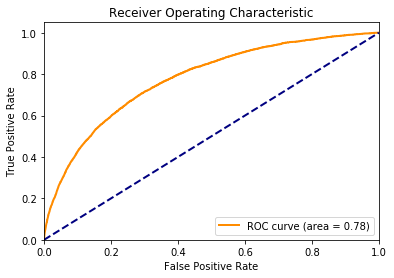

In [6]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()